# Child Seat Detection with EfficientDet

This notebook trains a model to classify child seat images and embeds metadata directly in the model.
Original images are 416x416 pixels but will be resized to 224x224 for better performance.

In [73]:
# Import necessary libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import json
from datetime import datetime

In [74]:
# Set environment variable to prevent TF from consuming all GPU memory
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

print("TensorFlow version:", tf.__version__)
print("GPU Available:", bool(tf.config.list_physical_devices('GPU')))

# Check and print available GPU memory
print("GPU Memory Information:")
try:
    print(f"TF GPU devices: {tf.config.list_physical_devices('GPU')}")
    # Only works if tensorflow-gpu is properly installed
    print(f"Available GPU memory: {tf.config.experimental.get_memory_info('GPU:0')}")
except:
    print("Could not retrieve detailed GPU memory information")

# Set memory growth for GPU to prevent OOM errors
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
            print(f"Memory growth set to True for GPU: {gpu}")
        except RuntimeError as e:
            print(f"Error setting memory growth: {e}")

# Clear GPU memory if possible
try:
    keras.backend.clear_session()
    print("Keras session cleared")
except:
    pass

TensorFlow version: 2.17.1
GPU Available: True
GPU Memory Information:
TF GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Available GPU memory: {'current': 218658304, 'peak': 1269634048}
Error setting memory growth: Physical devices cannot be modified after being initialized
Keras session cleared


In [75]:
# Configure paths and parameters
# BASE_DIR = '/kaggle/input/d/mihaiciprianchezan/child-seats/'
BASE_DIR = '/kaggle/input/cs3-dataset'

TRAIN_DIR = f'{BASE_DIR}/train' 
VALID_DIR = f'{BASE_DIR}/valid'
TEST_DIR = f'{BASE_DIR}/test'
OUTPUT_DIR = '/kaggle/working/output'

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Model parameters
ORIGINAL_IMG_SIZE = 416  # Original image size
IMG_SIZE = 224  # Resized for model training
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.0001

In [76]:
# Metadata to embed in the model
MODEL_METADATA = {
    "model_name": "child_seat_detector",
    "version": "1.0.0",
    "created_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "author": "AI Researcher",
    "description": "Model trained to detect child seats in images",
    "classes": ["child_seat", "other"],  # Updated to include both classes
    "input_size": IMG_SIZE,
    "original_image_size": ORIGINAL_IMG_SIZE,
    "training_platform": "Kaggle P100 GPU"
}


In [77]:
# Prepare dataset - Handle folder structure with ONLY positive examples
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_dataset_with_single_class():
    """
    Create datasets from folders containing only positive examples (child seat images).
    Images are resized from original to 224x224 for training efficiency.
    """
    # Data generators with augmentation
    train_datagen = ImageDataGenerator(
        rescale=1. / 255,  # Normalizing images
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Less augmentation for validation and test
    valid_test_datagen = ImageDataGenerator(rescale=1. / 255)

    # Load datasets directly from folders with single class
    print(f"Loading datasets and resizing images from {ORIGINAL_IMG_SIZE}x{ORIGINAL_IMG_SIZE} to {IMG_SIZE}x{IMG_SIZE}")

    # Check if directories exist
    for directory in [TRAIN_DIR, VALID_DIR, TEST_DIR]:
        if not os.path.exists(directory):
            print(f"WARNING: Directory {directory} does not exist!")
        else:
            print(f"Found directory: {directory}")
            print(f"Contents: {os.listdir(directory)[:10]} ...")

    train_dataset = tf.keras.utils.image_dataset_from_directory(
        TRAIN_DIR,
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True,
        label_mode='int',
        labels='inferred',  # All images are positive class
        color_mode='rgb',
        seed=42
    )

    valid_dataset = tf.keras.utils.image_dataset_from_directory(
        VALID_DIR,
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=False,
        label_mode='int',
        labels='inferred',
        color_mode='rgb',
        seed=42
    )

    test_dataset = tf.keras.utils.image_dataset_from_directory(
        TEST_DIR,
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=False,
        label_mode='int',
        labels='inferred',
        color_mode='rgb',
        seed=42
    )
    
    # Configure datasets for performance
    AUTOTUNE = tf.data.AUTOTUNE
    train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    valid_dataset = valid_dataset.cache().prefetch(buffer_size=AUTOTUNE)
    test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

    # Count samples
    train_count = sum(1 for _ in tf.data.Dataset.unbatch(train_dataset))
    valid_count = sum(1 for _ in tf.data.Dataset.unbatch(valid_dataset))
    test_count = sum(1 for _ in tf.data.Dataset.unbatch(test_dataset))

    print(f"Training images: {train_count}")
    print(f"Validation images: {valid_count}")
    print(f"Test images: {test_count}")

    return train_dataset, valid_dataset, test_dataset

In [80]:
def create_dataset_with_multiple_classes():
    """
    Create datasets from folders containing both child seat images and other images.
    This is now a multi-class object detection task.
    Images are resized from original to 224x224 for training efficiency.
    """
    # Data generators with augmentation
    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        rotation_range=40,  # Increase rotation
        width_shift_range=0.3,  # More shifting
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,  # Add vertical flip
        brightness_range=[0.6, 1.4],  # More brightness variation
        fill_mode='nearest',
        channel_shift_range=0.2  # Add channel shifts
    )

    # Less augmentation for validation and test
    valid_test_datagen = ImageDataGenerator(rescale=1. / 255)

    # Load datasets directly from folders with multiple classes
    print(f"Loading datasets and resizing images from {ORIGINAL_IMG_SIZE}x{ORIGINAL_IMG_SIZE} to {IMG_SIZE}x{IMG_SIZE}")

    # Check if directories exist
    for directory in [TRAIN_DIR, VALID_DIR, TEST_DIR]:
        if not os.path.exists(directory):
            print(f"WARNING: Directory {directory} does not exist!")
        else:
            print(f"Found directory: {directory}")
            print(f"Contents: {os.listdir(directory)[:10]} ...")

    train_dataset = tf.keras.utils.image_dataset_from_directory(
        TRAIN_DIR,
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True,
        label_mode='int',
        labels='inferred',  # Will infer labels from subdirectories
        color_mode='rgb',
        seed=42
    )

    class_names = train_dataset.class_names


    valid_dataset = tf.keras.utils.image_dataset_from_directory(
        VALID_DIR,
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=False,
        label_mode='int',
        labels='inferred',
        color_mode='rgb',
        seed=42
    )

    test_dataset = tf.keras.utils.image_dataset_from_directory(
        TEST_DIR,
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=False,
        label_mode='int',
        labels='inferred',
        color_mode='rgb',
        seed=42
    )

    # Configure datasets for performance
    AUTOTUNE = tf.data.AUTOTUNE
    train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    valid_dataset = valid_dataset.cache().prefetch(buffer_size=AUTOTUNE)
    test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

    # Count samples
    train_count = sum(1 for _ in tf.data.Dataset.unbatch(train_dataset))
    valid_count = sum(1 for _ in tf.data.Dataset.unbatch(valid_dataset))
    test_count = sum(1 for _ in tf.data.Dataset.unbatch(test_dataset))

    print(f"Training images: {train_count}")
    print(f"Validation images: {valid_count}")
    print(f"Test images: {test_count}")

    return train_dataset, valid_dataset, test_dataset, class_names


In [ ]:
# Create datasets
train_dataset, valid_dataset, test_dataset, class_names = create_dataset_with_multiple_classes()

print(f"Class names: {class_names}")

# Show some sample images
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(min(9, len(images))):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"{class_names[labels[i]]}")
        plt.axis("off")
plt.tight_layout()
plt.show()


In [82]:
# Build model with EfficientNet and metadata embedding
def build_model_with_metadata():
    """Build a model using EfficientNetB0 for multi-class detection and embed metadata"""

    print("\nBuilding EfficientNetB0 model for multi-class detection...")

    # Determine number of classes from metadata
    num_classes = len(MODEL_METADATA["classes"])
    print(f"Building model for {num_classes} classes: {MODEL_METADATA['classes']}")

    # Base model
    base_model = tf.keras.applications.EfficientNetB0(
        weights='imagenet',
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        pooling='avg'
    )

    # Freeze the base model layers
    base_model.trainable = False

    # Create the model
    inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base_model(inputs, training=False)
    x = keras.layers.Dense(256, activation='relu')(x)
    x = keras.layers.Dropout(0.2)(x)
    # Changed to softmax with num_classes outputs for multi-class classification
    outputs = keras.layers.Dense(num_classes, activation='softmax', name='class_output')(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name='object_detector')

    # Add metadata to the model as a custom attribute
    # Convert metadata to JSON string and add to model attributes
    metadata_json = json.dumps(MODEL_METADATA, indent=2)

    # Add as custom object
    model.metadata = metadata_json

    # Store metadata in model config as well for better persistence
    model._metadata = MODEL_METADATA

    # Make the entire model trainable
    base_model = model.get_layer('efficientnetb0')  # Get the EfficientNet layer
    base_model.trainable = True  # Make all layers trainable

    # OPTION: For fine-tuning after initial training
    base_model.trainable = True
    # Freeze earlier layers, unfreeze later layers for fine-tuning
    for layer in base_model.layers[:-20]:
        layer.trainable = False
    # Use a lower learning rate for fine-tuning
    fine_tune_lr = LEARNING_RATE / 10

    # Compile model with sparse_categorical_crossentropy for multi-class classification
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='sparse_categorical_crossentropy',  # Changed from binary_crossentropy
        metrics=[
            'accuracy',
            # Updated metrics for multi-class
            tf.keras.metrics.SparseCategoricalAccuracy(),
            tf.keras.metrics.SparseTopKCategoricalAccuracy(k=1, name='top_1_accuracy')
        ]
    )

    # Print model summary
    model.summary()

    # Print the embedded metadata
    print("\nModel Metadata:")
    print(metadata_json)

    return model


In [83]:
# Create model with embedded metadata
model = build_model_with_metadata()


Building EfficientNetB0 model for multi-class detection...
Building model for 2 classes: ['child_seat', 'other']


Model: "object_detector"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 1280)                │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ class_output (Dense)                 │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,378,021 (16.70 MB)

 Trainable params: 1,458,226 (5.56 MB)

 Non-trainable params: 2,919,795 (11.14 MB)


Model Metadata:
{
  "model_name": "child_seat_detector",
  "version": "1.0.0",
  "created_date": "2025-03-30 18:47:02",
  "author": "AI Researcher",
  "description": "Model trained to detect child seats in images",
  "classes": [
    "child_seat",
    "other"
  ],
  "input_size": 224,
  "original_image_size": 416,
  "training_platform": "Kaggle P100 GPU"
}


In [84]:
# Function to save custom model with metadata
def save_model_with_metadata(model, path):
    """Save model with metadata both as attribute and in a separate file"""

    # First save the model
    model.save(path)

    # Also save the metadata in a separate file for easy access
    metadata_path = os.path.join(os.path.dirname(path), 'model_metadata.json')
    with open(metadata_path, 'w') as f:
        json.dump(MODEL_METADATA, f, indent=2)

    print(f"Model saved to {path}")
    print(f"Metadata saved separately to {metadata_path}")

    return path

In [85]:
# Custom function to load model with metadata
def load_model_with_metadata(path):
    """Load a model and its metadata"""
    custom_objects = {
        'metadata': lambda: None  # This allows loading the model without complaining about metadata
    }

    loaded_model = keras.models.load_model(path, custom_objects=custom_objects)

    # Check for metadata file
    metadata_path = os.path.join(os.path.dirname(path), 'model_metadata.json')
    if os.path.exists(metadata_path):
        with open(metadata_path, 'r') as f:
            metadata = json.load(f)
            print("Loaded metadata from file")
            loaded_model.metadata = json.dumps(metadata)

    return loaded_model

In [86]:
# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(OUTPUT_DIR, 'best_model.keras'),
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),
    keras.callbacks.TensorBoard(log_dir=os.path.join(OUTPUT_DIR, 'logs'))
]


In [87]:
# Train the model
print("\nTraining the model...")
print(f"Using batch size {BATCH_SIZE} and learning rate {LEARNING_RATE}")

history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)


Training the model...
Using batch size 32 and learning rate 0.0001
Epoch 1/50
109/110 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9254 - loss: 0.2184 - sparse_categorical_accuracy: 0.9254 - top_1_accuracy: 0.9254
Epoch 1: val_loss improved from inf to 0.00759, saving model to /kaggle/working/output/best_model.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 49s 252ms/step - accuracy: 0.9264 - loss: 0.2162 - sparse_categorical_accuracy: 0.9264 - top_1_accuracy: 0.9264 - val_accuracy: 0.9977 - val_loss: 0.0076 - val_sparse_categorical_accuracy: 0.9977 - val_top_1_accuracy: 0.9977 - learning_rate: 1.0000e-04
Epoch 2/50
109/110 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9996 - loss: 0.0085 - sparse_categorical_accuracy: 0.9996 - top_1_accuracy: 0.9996
Epoch 2: val_loss improved from 0.00759 to 0.00555, saving model to /kaggle/working/output/best_model.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9996 - loss: 0.0085 - sparse_categorical_accuracy: 0.9996 - top_1_accuracy: 0.999

In [88]:
# Save the final model with metadata
model_path = os.path.join(OUTPUT_DIR, 'child_seat_model.keras')
save_model_with_metadata(model, model_path)

Model saved to /kaggle/working/output/child_seat_model.keras
Metadata saved separately to /kaggle/working/output/model_metadata.json


'/kaggle/working/output/child_seat_model.keras'

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


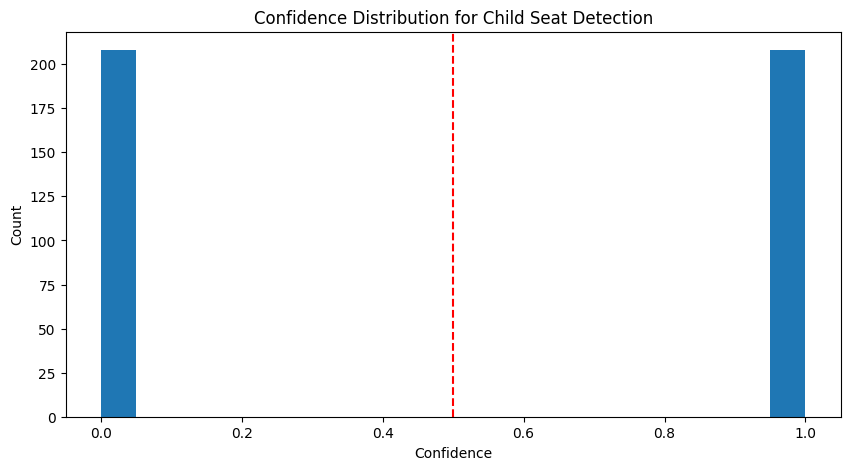

Average confidence: 0.5000
Min confidence: 0.0000
Max confidence: 1.0000


In [89]:
# After training
def evaluate_confidence(model, dataset):
    """Evaluate model by checking confidence distribution"""
    all_confidences = []

    for images, _ in dataset:
        preds = model.predict(images)
        all_confidences.extend(preds.flatten().tolist())

    plt.figure(figsize=(10, 5))
    plt.hist(all_confidences, bins=20)
    plt.title('Confidence Distribution for Child Seat Detection')
    plt.xlabel('Confidence')
    plt.ylabel('Count')
    plt.axvline(0.5, color='red', linestyle='--')
    plt.savefig(f'{OUTPUT_DIR}/confidence_distribution.png')
    plt.show()

    print(f"Average confidence: {np.mean(all_confidences):.4f}")
    print(f"Min confidence: {np.min(all_confidences):.4f}")
    print(f"Max confidence: {np.max(all_confidences):.4f}")


# Run the evaluation
evaluate_confidence(model, test_dataset)

In [90]:
# # Unfreeze the base model for fine-tuning
# base_model = model.get_layer('efficientnetb0')
# base_model.trainable = True

# # Freeze earlier layers, only fine-tune later layers
# for layer in base_model.layers[:-20]:
#     layer.trainable = False

# # Recompile model with a lower learning rate
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE/10),
#     loss='binary_crossentropy',
#     metrics=[
#         'accuracy',
#         tf.keras.metrics.BinaryAccuracy(threshold=0.5),
#         tf.keras.metrics.Precision(thresholds=0.5),
#         tf.keras.metrics.Recall(thresholds=0.5)
#     ]
# )

# # Fine-tune for fewer epochs
# fine_tune_history = model.fit(
#     train_dataset,
#     validation_data=valid_dataset,
#     epochs=20,
#     callbacks=callbacks,
#     verbose=1
# )

In [91]:
# # Save the fine-tuned model
# fine_tuned_model_path = os.path.join(OUTPUT_DIR, 'child_seat_model_fine_tuned.keras')
# save_model_with_metadata(model, fine_tuned_model_path)

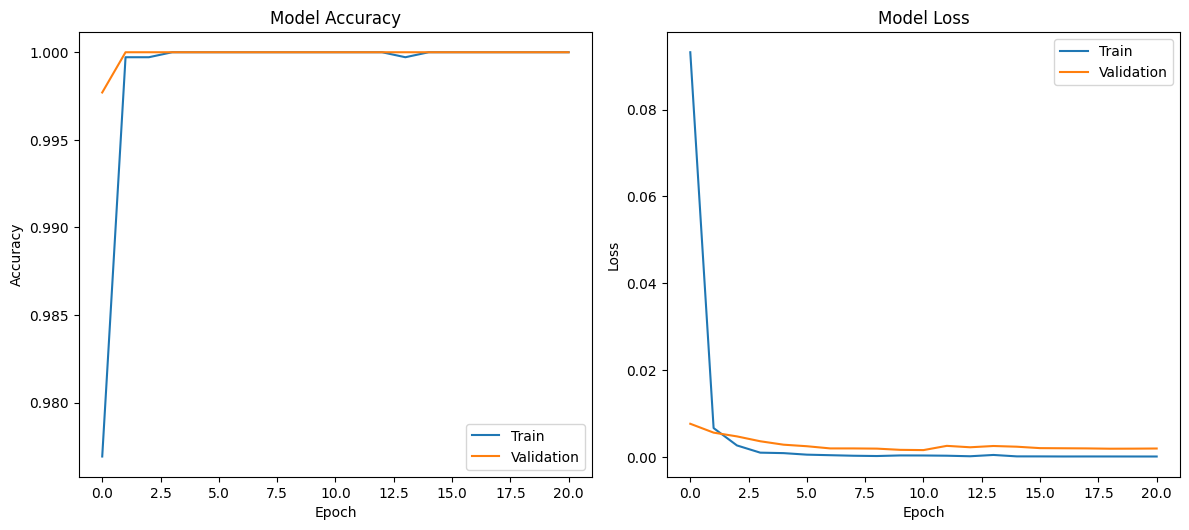

In [92]:
# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 10))

    # Plot accuracy
    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')

    # Plot loss
    plt.subplot(2, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot precision if available
    if 'precision' in history.history:
        plt.subplot(2, 2, 3)
        plt.plot(history.history['precision'])
        plt.plot(history.history['val_precision'])
        plt.title('Model Precision')
        plt.ylabel('Precision')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='lower right')

    # Plot recall if available
    if 'recall' in history.history:
        plt.subplot(2, 2, 4)
        plt.plot(history.history['recall'])
        plt.plot(history.history['val_recall'])
        plt.title('Model Recall')
        plt.ylabel('Recall')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='lower right')

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'training_history.png'))
    plt.show()


plot_history(history)

In [ ]:
# Evaluate the model
print("\nEvaluating model on test dataset...")
results = model.evaluate(test_dataset, return_dict=True)  # Use return_dict=True to get named metrics

# Extract the metrics you need
test_loss = results['loss']
test_acc = results['accuracy'] if 'accuracy' in results else results['binary_accuracy']
test_auc = results['auc'] if 'auc' in results else 0.0

print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Verify that metadata is preserved
print("\nVerifying metadata in saved model...")
try:
    loaded_model = load_model_with_metadata(model_path)
    if hasattr(loaded_model, 'metadata'):
        print("✓ Metadata successfully preserved in the model")
        print(loaded_model.metadata)
    else:
        print("✗ Metadata not found in loaded model")
except Exception as e:
    print(f"Error loading model: {e}")


# Visualize predictions on test images
def visualize_predictions(dataset, num_images=9):
    """Visualize model predictions on sample images"""
    plt.figure(figsize=(12, 12))

    # Get a batch of images
    images = []
    for img_batch, _ in dataset.take(1):
        images = img_batch.numpy()

    # Get predictions
    predictions = model.predict(images)

    # Plot images with predictions
    for i in range(min(num_images, len(images))):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].astype("uint8"))

        confidence = predictions[i][0]
        color = 'green' if confidence > 0.5 else 'red'

        plt.title(f"Child Seat: {confidence:.2f}", color=color)
        plt.axis("off")

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'prediction_samples.png'))
    plt.show()


print("\nVisualizing predictions on test images...")
visualize_predictions(test_dataset)
visualize_predictions(train_dataset)


In [109]:
# Create TFLite model with properly embedded metadata
print("\nCreating TFLite model with embedded metadata...")

# Configure the converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert the model
tflite_model = converter.convert()

# Save the model file
tflite_path = os.path.join(OUTPUT_DIR, 'child_seat_model.tflite')
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)

# Since TensorFlow metadata tools are failing, let's create a model that works with MediaPipe
# MediaPipe can use TFLite models without embedded metadata as long as we provide the labels separately

print("The metadata embedding is failing due to package conflicts.")
print("For MediaPipe, you can use the TFLite model directly with these class labels:")
for idx, label in enumerate(class_names):
    print(f"  {idx}: {label}")

# Save labels to a file that can be loaded alongside the model
labels_path = os.path.join(OUTPUT_DIR, 'labels.txt')
with open(labels_path, 'w') as f:
    f.write('\n'.join(class_names))

print(f"\nModel saved to: {tflite_path}")
print(f"Labels saved to: {labels_path}")
print("\nTo use this model with MediaPipe:")
print("1. Load the TFLite model")
print("2. Set the class labels manually in your code")
print("3. Or load the labels from the labels.txt file")

# Return the path to the model
tflite_model_path = tflite_path



Creating TFLite model with embedded metadata...
Saved artifact at '/tmp/tmp3peyos_7'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_239')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  132931542440720: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  132928398334032: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  132931520717120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132931520714480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132931520710784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132931520713424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132931520754288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132941830125024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132939207165200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1329315207095

The model